## Задача 1

Реализовать класс для работы с линейной регрессией

In [89]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20):
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None:
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None:
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")

        # Your code here
        # Дополнительное условие про невозможность матричного вычисления при 'l1' или 'l1l2'
        if regularization in ['l1', 'l1l2'] and weight_calc == 'matrix':
            raise TypeError(f"Нельзя использовать weight_calc = matrix с заданным параметром regularization.")

        # Добавление атрибутов
        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.coefs_ = None
        self.intercept_ = None

    def print_parameters(self):
      print("Регуляризация:", self.regularization)
      print("Метод вычисления:", self.weight_calc)
      print("Lambda 1:", self.lambda_1)
      print("Lambda 2:", self.lambda_2)
      print("Batch size:", self.batch_size)

      return None

    """
    ГРАДИЕНТ
    """

    def get_gradient(self, X,Y,W): # Функция взятия градиента
      grad = ((-2 / X.shape[0]) * (Y - X @ W)) @ X

      if self.regularization == 'l1':
        grad_l1 = self.lambda_1 * np.sign(W)
        grad_l1[0] = 0
        grad = grad + grad_l1
      if self.regularization == 'l2':
        grad_l2 = 2 * self.lambda_2 * W
        grad_l2[0] = 0
        grad = grad + grad_l2
      if self.regularization == 'l1l2':
        grad_l1 = self.lambda_1 * np.sign(W)
        grad_l1[0] = 0
        grad_l2 = 2 * self.lambda_2 * W
        grad_l2[0] = 0
        grad = grad + grad_l1 + grad_l2
      return grad

    """
    МАТРИЧНОЕ ВЫЧИСЛЕНИЕ
    """

    def MATRIX_fit(self, X: np.array, Y: np.array):
      """
      Без регуляризации
      """
      if self.regularization is None:
        try:
          Q = np.linalg.inv(X.T @ X) @ X.T @ Y
        except np.linalg.LinAlgError:
          Q = None
          print("Невозможно найти обратную матрицу для применения матричного метода.")

      """
      С l2 регуляризацией
      """
      if self.regularization == 'l2':
        try:
          mask = np.eye(X.shape[1])
          mask[0, 0] = 0
          Q = np.linalg.inv(X.T @ X + self.lambda_2 * mask) @ X.T @ Y
        except np.linalg.LinAlgError:
          Q = None
          print("Невозможно найти обратную матрицу для применения матричного метода.")

      return Q

    """
    ГРАДИЕНТНЫЙ СПУСК
    """

    def GD_fit(self, X: np.array, Y: np.array, W: np.array):
      alpha=0.001 # Параметры
      max_iter=50000
      early_stopping=0.0001

      for i in range(max_iter):
        grad = self.get_gradient(X,Y,W) # Градиент
        if np.linalg.norm(grad) < early_stopping: # Ранняя остановка
          break
        W = W - alpha * grad # Обновление весов
      return W

    """
    СТОХАСТИЧЕСКИЙ ГРАДИЕНТНЫЙ СПУСК
    """

    def SGD_fit(self, X: np.array, Y: np.array, W: np.array):
      alpha=0.001 # Параметры
      max_iter=50000
      early_stopping=0.0001

      for i in range(max_iter):
        inds = np.random.permutation(X.shape[0]) # Перемешиваем данные
        X_shuffled = X[inds]
        Y_shuffled = Y[inds]

        for b in range(0, X_shuffled.shape[0], self.batch_size):
          X_batch = X_shuffled[b:b+self.batch_size] # Выделяем подвыборки
          Y_batch = Y_shuffled[b:b+self.batch_size]

          grad = self.get_gradient(X_batch, Y_batch, W) # Градиент
          W = W - alpha * grad # Обновление весов

        if np.linalg.norm(grad) < early_stopping: # Ранняя остановка
          break

      return W


    """
    ОБУЧЕНИЕ
    """
    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        # Добавляем столбце фиктивных 1 слева
        X = X.to_numpy()
        Y = y.to_numpy().reshape(-1)
        X_with_ones = np.c_[np.ones(X.shape[0]), X]

        # Матричное счисление
        if self.weight_calc == 'matrix':
          coef_results = self.MATRIX_fit(X_with_ones, Y)

        else:
          W = np.random.uniform(size = X_with_ones.shape[1]) # Начально значение W

          # Градиентный спуск
          if self.weight_calc == 'gd':
            coef_results = self.GD_fit(X_with_ones, Y, W)

          # Стохастический градиентный спуск
          if self.weight_calc == 'sgd':
            coef_results = self.SGD_fit(X_with_ones, Y, W)

        self.intercept_ = coef_results[0]
        self.coefs_ = coef_results[1:]


    def predict(self, X: np.array, ss=True):
      if self.coefs_ is None or self.intercept_ is None:
        raise Exception("Модель не обучена")
      y_pred = X @ self.coefs_ + self.intercept_
      return y_pred

    def score(self, X: np.array, y: np.array):
      y_pred = self.predict(X)
      y_mean = y.mean()

      SSres = (np.square(y - y_pred)).sum()
      SStot = (np.square(y - y_mean)).sum()

      if SStot == 0:
        if SSres == 0:
            return 1
        else:
            return 0

      return 1 - SSres/SStot

Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [90]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import time

In [91]:
df = pd.read_csv("/content/Used_fiat_500_in_Italy_dataset.csv")
print(df.head(5))

    model  engine_power transmission  age_in_days      km  previous_owners  \
0     pop            69       manual         4474   56779                2   
1  lounge            69       manual         2708  160000                1   
2  lounge            69    automatic         3470  170000                2   
3   sport            69       manual         3288  132000                2   
4   sport            69       manual         3712  124490                2   

         lat       lon  price  
0  45.071079   7.46403   4490  
1  45.069679   7.70492   4500  
2  45.514599   9.28434   4500  
3  41.903221  12.49565   4700  
4  45.532661   9.03892   4790  


In [92]:
df.isna().sum()

,0
model,0
engine_power,0
transmission,0
age_in_days,0
km,0
previous_owners,0
lat,0
lon,0
price,0


In [93]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1), df['price'], test_size=0.2, random_state=42)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
X_train.head()

,engine_power,age_in_days,km,previous_owners,lat,lon,model_pop,model_sport,model_star,transmission_manual
77,69,397,18324,2,45.436100,8.88787,False,False,False,True
220,69,4169,81900,2,45.443272,10.23021,False,False,False,True
297,69,548,82000,1,45.438301,10.99170,True,False,False,False
113,69,4414,149326,2,45.810711,9.08715,False,False,False,True
203,99,4535,120000,2,44.410389,8.93898,False,False,False,True


In [94]:
X_test = X_test.reindex(columns = X_train.columns, fill_value=0)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [95]:
def My_reg_call(X_train, y_train, X_test, y_test, my_reg):

  start_time = time.time()
  my_reg.fit(X_train_scaled, y_train)

  X_test_np = X_test.to_numpy()
  y_test_np = y_test.to_numpy().reshape(-1)

  y_pred = my_reg.predict(X_test_np)

  end_time = time.time()
  execution_time = end_time - start_time

  score = my_reg.score(X_test_np, y_test_np)

  return (score, execution_time, my_reg.intercept_, my_reg.coefs_)

In [97]:
my_reg_results = list()

""" matrix """
w = 'matrix'

r = None
my_reg = MyLinearRegression(weight_calc = w, regularization = r)
res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)

my_reg_results.append([w, 'None', None, None, None, res])

r = 'l2'
for l_2 in range (1, 40, 10):
  my_reg = MyLinearRegression(weight_calc = w, regularization = r, lambda_2 = l_2 / 10)
  res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)

  my_reg_results.append([w, r, None, l_2 / 10, None, res])

""" gd """
w = 'gd'

r = None
my_reg = MyLinearRegression(weight_calc = w, regularization = r)
res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)

my_reg_results.append([w, 'None', None, None, None, res])

r = 'l1'
for l_1 in range (1, 40, 10):
  my_reg = MyLinearRegression(weight_calc = w, regularization = r, lambda_1 = l_1 / 10)
  res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)

  my_reg_results.append([w, r, l_1 / 10, None, None, res])

r = 'l2'
for l_2 in range (1, 40, 10):
  my_reg = MyLinearRegression(weight_calc = w, regularization = r, lambda_2 = l_2 / 10)
  res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)
  my_reg_results.append([w, r, None, l_2 / 10, None, res])

r = 'l1l2'
for l_1 in range (1, 40, 10):
  for l_2 in range (1, 40, 10):
    my_reg = MyLinearRegression(weight_calc = w, regularization = r, lambda_1 = l_1 / 10, lambda_2 = l_2 / 10)
    res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)
    my_reg_results.append([w, r, l_1 / 10, l_2 / 10, None, res])

""" sgd """
w = 'sgd'

for batch in range(10, 90, 20):
  r = None
  my_reg = MyLinearRegression(weight_calc = w, regularization = r, batch_size = batch)
  res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)
  my_reg_results.append([w, 'None', None, None, batch, res])

  r = 'l1'
  for l_1 in range (1, 40, 10):
    my_reg = MyLinearRegression(weight_calc = w, regularization = r, lambda_1 = l_1 / 10, batch_size = batch)
    res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)
    my_reg_results.append([w, r, l_1 / 10, None, batch, res])

  r = 'l2'
  for l_2 in range (1, 40, 10):
    my_reg = MyLinearRegression(weight_calc = w, regularization = r, lambda_2 = l_2 / 10, batch_size = batch)
    res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)
    my_reg_results.append([w, r, None, l_2 / 10, batch, res])

  r = 'l1l2'
  for l_1 in range (1, 40, 10):
    for l_2 in range (1, 40, 10):
      my_reg = MyLinearRegression(weight_calc = w, regularization = r, lambda_1 = l_1 / 10, lambda_2 = l_2 / 10, batch_size = batch)
      res = My_reg_call(X_train_scaled, y_train, X_test_scaled, y_test, my_reg)
      my_reg_results.append([w, r, l_1 / 10, l_2 / 10, batch, res])

In [98]:
df_results = pd.DataFrame(my_reg_results, columns = ["weight_calc", "regularization", "lambda_1", "lambda_2", "batch_size", "result"])

In [99]:
df_results[['score', 'execution_time', 'intercept_', 'coefs_']] = pd.DataFrame(
    df_results['result'].tolist(),
    index=df_results.index
)

summary_by_method = df_results.groupby(['weight_calc', 'regularization']).agg({
    'score': ['mean', 'std', 'max', 'min'],
    'execution_time': ['mean', 'sum'],
    'intercept_': 'mean'
}).round(4)

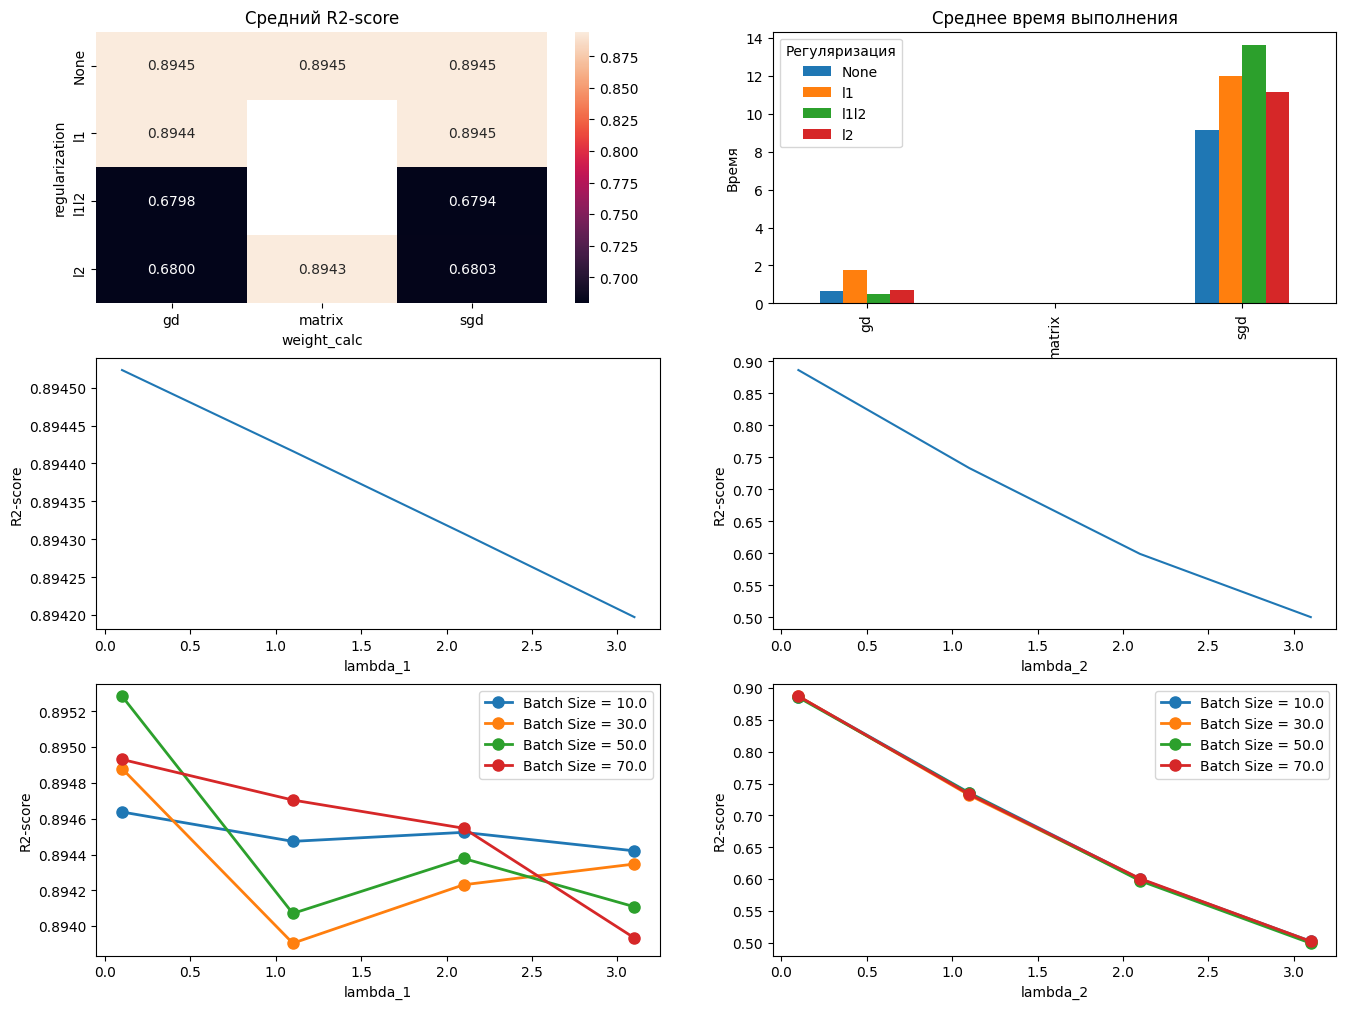

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(3, 2, figsize=(16, 12))

plt.subplot(3, 2, 1)
heatmap_data = df_results.pivot_table(
    index='regularization',
    columns='weight_calc',
    values='score',
    aggfunc='mean')
sns.heatmap(heatmap_data, annot=True, fmt='.4f')
plt.title('Средний R2-score')


plt.subplot(3, 2, 2)
time_by_method = df_results.groupby(['weight_calc', 'regularization'])['execution_time'].mean().unstack()
time_by_method.plot(kind='bar', ax=plt.gca())
plt.title('Среднее время выполнения')
plt.ylabel('Время')
plt.legend(title='Регуляризация')

plt.subplot(3, 2, 3)
score_by_lambda = df_results[(df_results['weight_calc'] == 'gd') & (df_results['regularization'] == 'l1')]
x = score_by_lambda['lambda_1'].values
s = score_by_lambda['score'].values
plt.ylabel('R2-score')
plt.xlabel('lambda_1')
plt.plot(x, s)

plt.subplot(3, 2, 4)
score_by_lambda = df_results[(df_results['weight_calc'] == 'gd') & (df_results['regularization'] == 'l2')]
x = score_by_lambda['lambda_2'].values
s = score_by_lambda['score'].values
plt.ylabel('R2-score')
plt.xlabel('lambda_2')
plt.plot(x, s)

plt.subplot(3, 2, 5)
score_by_lambda = df_results[(df_results['weight_calc'] == 'sgd') & (df_results['regularization'] == 'l1')]
for batch in sorted(score_by_lambda['batch_size'].dropna().unique()):
   df_batch = score_by_lambda[score_by_lambda['batch_size'] == batch].copy()
   df_batch = df_batch.sort_values('lambda_1')
   plt.plot(df_batch['lambda_1'], df_batch['score'],
                    marker='o', linewidth=2, markersize=8,
                    label=f'Batch Size = {batch}')
plt.ylabel('R2-score')
plt.xlabel('lambda_1')
plt.legend()

plt.subplot(3, 2, 6)
score_by_lambda = df_results[(df_results['weight_calc'] == 'sgd') & (df_results['regularization'] == 'l2')]
for batch in sorted(score_by_lambda['batch_size'].dropna().unique()):
   df_batch = score_by_lambda[score_by_lambda['batch_size'] == batch].copy()
   df_batch = df_batch.sort_values('lambda_2')
   plt.plot(df_batch['lambda_2'], df_batch['score'],
                    marker='o', linewidth=2, markersize=8,
                    label=f'Batch Size = {batch}')
plt.ylabel('R2-score')
plt.xlabel('lambda_2')
plt.legend()

Text(0.5, 0, 'R2-score')

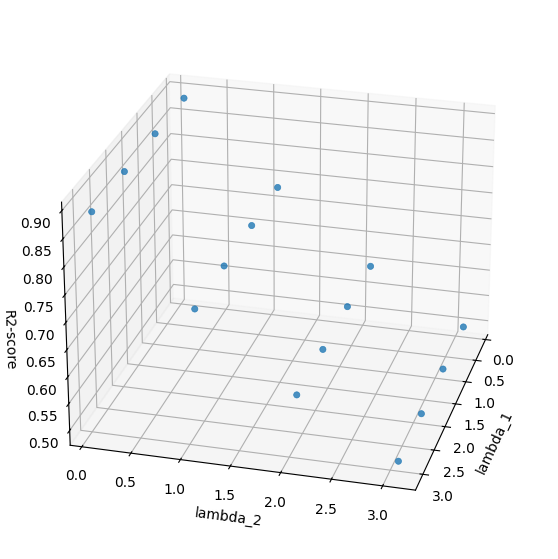

In [101]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(7, 7))

score_by_lambda = df_results[(df_results['weight_calc'] == 'gd') & (df_results['regularization'] == 'l1l2')]
score_by_lambda = score_by_lambda.sort_values(['lambda_1', 'lambda_2'])

x = score_by_lambda['lambda_1'].values
y = score_by_lambda['lambda_2'].values
z = score_by_lambda['score'].values

ax.scatter(x, y, z, alpha=0.8, linewidth=0.5)

ax.view_init(elev=25, azim=15)
ax.grid(True, alpha=0.3)

ax.set_xlabel('lambda_1')
ax.set_ylabel('lambda_2')
ax.set_zlabel('R2-score')

In [108]:
coefs_by_reg = df_results[(df_results['weight_calc'] == 'matrix')]

coefs_by_reg["intercept_"] = coefs_by_reg["intercept_"].apply(lambda x: round(x, 3))
coefs_by_reg["coefs_"] = coefs_by_reg["coefs_"].apply(lambda x: [round(c, 3) for c in x])

/tmp/ipython-input-3573178935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_by_reg["intercept_"] = coefs_by_reg["intercept_"].apply(lambda x: round(x, 3))
/tmp/ipython-input-3573178935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coefs_by_reg["coefs_"] = coefs_by_reg["coefs_"].apply(lambda x: [round(c, 3) for c in x])


In [109]:
pd.set_option('display.max_rows', None)

for id, r in coefs_by_reg[["regularization", "lambda_2", "intercept_", "coefs_"]].iterrows():
  print("\n", r["regularization"], r["lambda_2"])
  print("Коэффициенты: ", *r["coefs_"], sep = ', ')


 None nan
Коэффициенты: , 39.824, -1533.838, -556.685, 50.413, 194.474, 252.261, 46.635, 54.641, 35.701, -3.125

 l2 0.1
Коэффициенты: , 39.716, -1532.999, -557.039, 50.412, 194.152, 251.924, 46.51, 54.52, 35.757, -3.154

 l2 1.1
Коэффициенты: , 38.647, -1524.7, -560.503, 50.4, 190.989, 248.605, 45.277, 53.323, 36.311, -3.444

 l2 2.1
Коэффициенты: , 37.59, -1516.557, -563.845, 50.382, 187.912, 245.368, 44.068, 52.148, 36.854, -3.725

 l2 3.1
Коэффициенты: , 36.544, -1508.565, -567.07, 50.359, 184.917, 242.212, 42.882, 50.993, 37.387, -3.996


In [104]:
""" Без регуляризации """

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred_lr = lin_reg.predict(X_test_scaled)
print("R2-score без регуляризации:", r2_score(y_test, y_pred_lr))

""" Lasso """

lasso_reg = Lasso()
lasso_reg.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_reg.predict(X_test_scaled)
print("R2-score с регуляризацией l1:", r2_score(y_test, y_pred_lasso))

""" Ridge """

ridge_reg = Ridge()
ridge_reg.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_reg.predict(X_test_scaled)
print("R2-score с регуляризацией l2:", r2_score(y_test, y_pred_ridge))

""" Elastic Net  """

en_reg = ElasticNet()
en_reg.fit(X_train_scaled, y_train)
y_pred_en = en_reg.predict(X_test_scaled)
print("R2-score с регуляризацией l1l2:", r2_score(y_test, y_pred_en))

R2-score без регуляризации: 0.8945337093911586
R2-score с регуляризацией l1: 0.8943166487049659
R2-score с регуляризацией l2: 0.8943951595158497
R2-score с регуляризацией l1l2: 0.8294867634290108
